# Kernel Ridge Regression

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/kernel-ridge-regression/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/kernel-ridge-regression/).*

Building on linear regression, we can fit non-linear data sets by introducing a feature space. In a higher-dimensional feature space, we can overfit the data; ridge regression introduces regularization to avoid this. In this notebook we show how we can use KernelFunctions.jl for *kernel* ridge regression.

In [1]:
# Loading and setup of required packages
using KernelFunctions
using LinearAlgebra
using Distributions

# Plotting
using Plots;
default(; lw=2.0, legendfontsize=11.0, ylims=(-150, 500));

using Random: seed!
seed!(42);

## Toy data
Here we use a one-dimensional toy problem. We generate data using the fourth-order polynomial $f(x) = (x+4)(x+1)(x-1)(x-3)$:

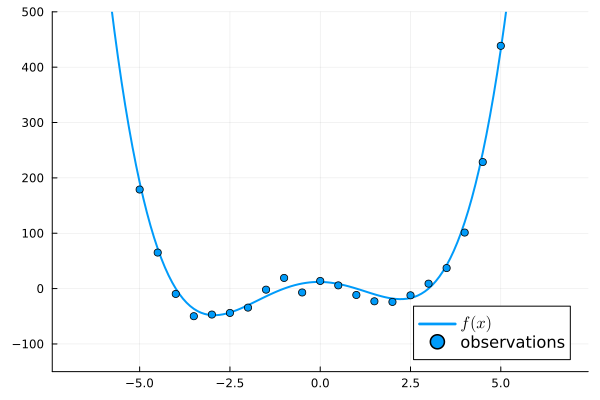

In [2]:
f_truth(x) = (x + 4) * (x + 1) * (x - 1) * (x - 3)

x_train = -5:0.5:5
x_test = -7:0.1:7

noise = rand(Uniform(-20, 20), length(x_train))
y_train = f_truth.(x_train) + noise
y_test = f_truth.(x_test)

plot(x_test, y_test; label=raw"$f(x)$")
scatter!(x_train, y_train; seriescolor=1, label="observations")

## Linear regression
For training inputs $\mathrm{X}=(\mathbf{x}_n)_{n=1}^N$ and observations $\mathbf{y}=(y_n)_{n=1}^N$, the linear regression weights $\mathbf{w}$ using the least-squares estimator are given by
$$
\mathbf{w} = (\mathrm{X}^\top \mathrm{X})^{-1} \mathrm{X}^\top \mathbf{y}
$$
We predict at test inputs $\mathbf{x}_*$ using
$$
\hat{y}_* = \mathbf{x}_*^\top \mathbf{w}
$$
This is implemented by `linear_regression`:

In [3]:
function linear_regression(X, y, Xstar)
    weights = (X' * X) \ (X' * y)
    return Xstar * weights
end;

A linear regression fit to the above data set:

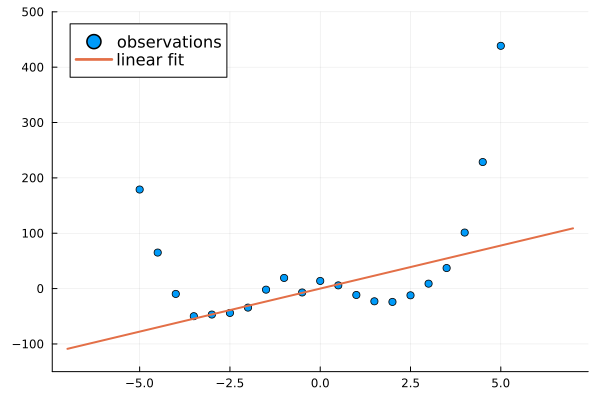

In [4]:
y_pred = linear_regression(x_train, y_train, x_test)
scatter(x_train, y_train; label="observations")
plot!(x_test, y_pred; label="linear fit")

## Featurization
We can improve the fit by including additional features, i.e. generalizing to $\tilde{\mathrm{X}} = (\phi(x_n))_{n=1}^N$, where $\phi(x)$ constructs a feature vector for each input $x$. Here we include powers of the input, $\phi(x) = (1, x, x^2, \dots, x^d)$:

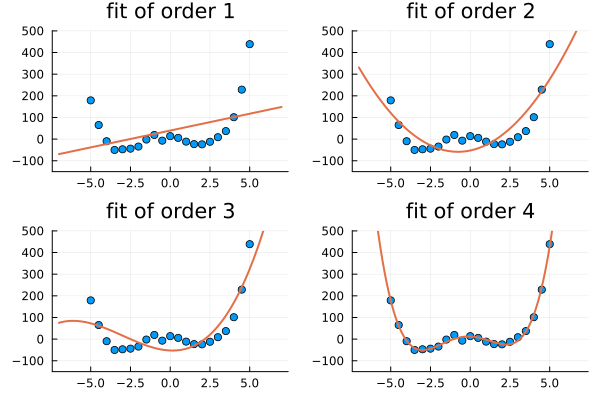

In [5]:
function featurize_poly(x; degree=1)
    return repeat(x, 1, degree + 1) .^ (0:degree)'
end

function featurized_fit_and_plot(degree)
    X = featurize_poly(x_train; degree=degree)
    Xstar = featurize_poly(x_test; degree=degree)
    y_pred = linear_regression(X, y_train, Xstar)
    scatter(x_train, y_train; legend=false, title="fit of order $degree")
    return plot!(x_test, y_pred)
end

plot((featurized_fit_and_plot(degree) for degree in 1:4)...)

Note that the fit becomes perfect when we include exactly as many orders in the features as we have in the underlying polynomial (4).

However, when increasing the number of features, we can quickly overfit to noise in the data set:

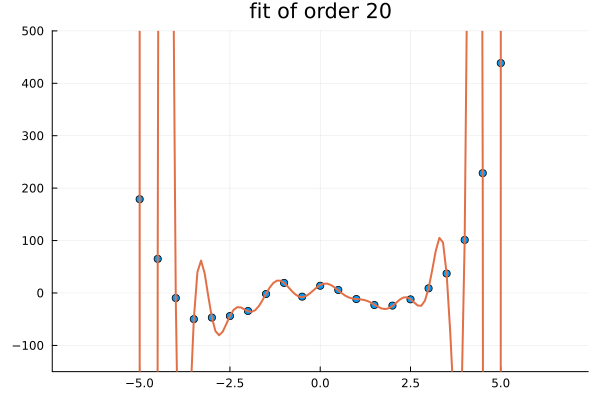

In [6]:
featurized_fit_and_plot(20)

## Ridge regression
To counteract this unwanted behaviour, we can introduce regularization. This leads to *ridge regression* with $L_2$ regularization of the weights ([Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)).
Instead of the weights in linear regression,
$$
\mathbf{w} = (\mathrm{X}^\top \mathrm{X})^{-1} \mathrm{X}^\top \mathbf{y}
$$
we introduce the ridge parameter $\lambda$:
$$
\mathbf{w} = (\mathrm{X}^\top \mathrm{X} + \lambda \mathbb{1})^{-1} \mathrm{X}^\top \mathbf{y}
$$
As before, we predict at test inputs $\mathbf{x}_*$ using
$$
\hat{y}_* = \mathbf{x}_*^\top \mathbf{w}
$$
This is implemented by `ridge_regression`:

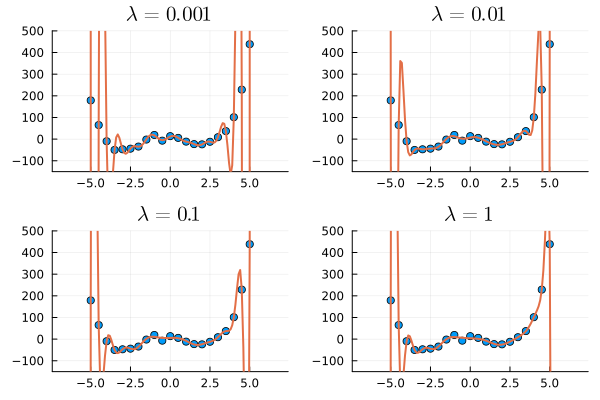

In [7]:
function ridge_regression(X, y, Xstar, lambda)
    weights = (X' * X + lambda * I) \ (X' * y)
    return Xstar * weights
end

function regularized_fit_and_plot(degree, lambda)
    X = featurize_poly(x_train; degree=degree)
    Xstar = featurize_poly(x_test; degree=degree)
    y_pred = ridge_regression(X, y_train, Xstar, lambda)
    scatter(x_train, y_train; legend=false, title="\$\\lambda=$lambda\$")
    return plot!(x_test, y_pred)
end

plot((regularized_fit_and_plot(20, lambda) for lambda in (1e-3, 1e-2, 1e-1, 1))...)

## Kernel ridge regression
Instead of constructing the feature matrix explicitly, we can use *kernels* to replace inner products of feature vectors with a kernel evaluation: $\langle \phi(x), \phi(x') \rangle = k(x, x')$ or $\tilde{\mathrm{X}} \tilde{\mathrm{X}}^\top = \mathrm{K}$, where $\mathrm{K}_{ij} = k(x_i, x_j)$.

To apply this "kernel trick" to ridge regression, we can rewrite the ridge estimate for the weights
$$
\mathbf{w} = (\mathrm{X}^\top \mathrm{X} + \lambda \mathbb{1})^{-1} \mathrm{X}^\top \mathbf{y}
$$
using the [matrix inversion lemma](https://tlienart.github.io/pub/csml/mtheory/matinvlem.html#basic_lemmas)
as
$$
\mathbf{w} = \mathrm{X}^\top (\mathrm{X} \mathrm{X}^\top + \lambda \mathbb{1})^{-1} \mathbf{y}
$$
where we can now replace the inner product with the kernel matrix,
$$
\mathbf{w} = \mathrm{X}^\top (\mathrm{K} + \lambda \mathbb{1})^{-1} \mathbf{y}
$$
And the prediction yields another inner product,
$$
\hat{y}_* = \mathbf{x}_*^\top \mathbf{w} = \langle \mathbf{x}_*, \mathbf{w} \rangle = \mathbf{k}_* (\mathrm{K} + \lambda \mathbb{1})^{-1} \mathbf{y}
$$
where $(\mathbf{k}_*)_n = k(x_*, x_n)$.

This is implemented by `kernel_ridge_regression`:

In [8]:
function kernel_ridge_regression(k, X, y, Xstar, lambda)
    K = kernelmatrix(k, X)
    kstar = kernelmatrix(k, Xstar, X)
    return kstar * ((K + lambda * I) \ y)
end;

Now, instead of explicitly constructing features, we can simply pass in a `PolynomialKernel` object:

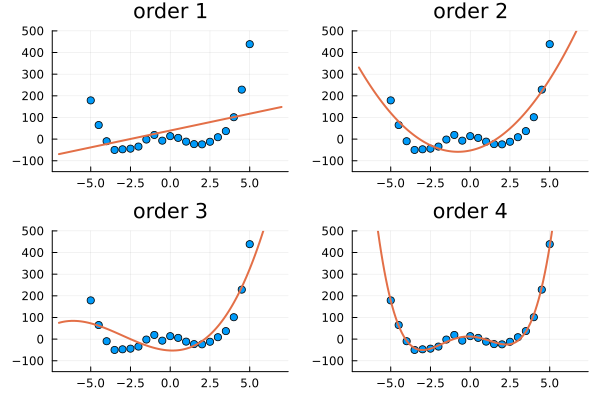

In [9]:
function kernelized_fit_and_plot(kernel, lambda=1e-4)
    y_pred = kernel_ridge_regression(kernel, x_train, y_train, x_test, lambda)
    if kernel isa PolynomialKernel
        title = string("order ", kernel.degree)
    else
        title = string(nameof(typeof(kernel)))
    end
    scatter(x_train, y_train; label=nothing)
    return plot!(x_test, y_pred; label=nothing, title=title)
end

plot((kernelized_fit_and_plot(PolynomialKernel(; degree=degree, c=1)) for degree in 1:4)...)

However, we can now also use kernels that would have an infinite-dimensional feature expansion, such as the squared exponential kernel:

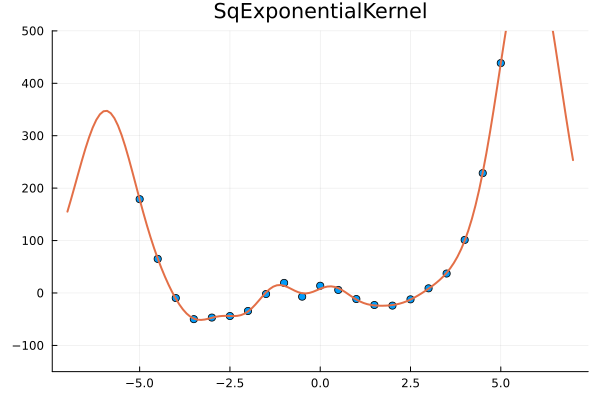

In [10]:
kernelized_fit_and_plot(SqExponentialKernel())

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/KernelFunctions.jl/KernelFunctions.jl/examples/kernel-ridge-regression/Project.toml&#96;
  &#91;31c24e10&#93; Distributions v0.25.123
  &#91;ec8451be&#93; KernelFunctions v0.10.66 &#96;/home/runner/work/KernelFunctions.jl/KernelFunctions.jl#master&#96;
  &#91;98b081ad&#93; Literate v2.21.0
  &#91;91a5bcdd&#93; Plots v1.41.4
  &#91;37e2e46d&#93; LinearAlgebra v1.12.0
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.12.4
Commit 01a2eadb047 &#40;2026-01-06 16:56 UTC&#41;
Build Info:
  Official https://julialang.org release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × Intel&#40;R&#41; Xeon&#40;R&#41; Platinum 8370C CPU @ 2.80GHz
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 &#40;ORCJIT, icelake-server&#41;
  GC: Built with stock GC
Threads: 1 default, 1 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*